### **Load Necessary Libraries**

In [ ]:
# pip install timm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json
import os
import random
from collections import defaultdict
from PIL import Image
from google.colab import drive
from zipfile import ZipFile
from google.colab import files
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
test_tfms = valid_tfms

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

'<|endoftext|>'

In [ ]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx, :]
        image_path = sample['Image_Path']
        caption = sample['Class_Label']

        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        augs = self.tfms(image=image)
        image = augs['image']

        caption = f"{caption}"
        input_ids = tokenizer(
            caption,
            truncation=True
        )['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]

        return image, input_ids, labels


### **Load and Preprocess the Dataset**

The code snippets that follows uses various methods to load the datsets from the web. There is no single method to do this, dataset can be loaded from the web with different method.

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text_data = f.read()


--2024-03-20 16:30:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-03-20 16:30:24 (53.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# !pip install kaggle

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinsogiekpolor","key":"a7ce4cc6a4c4cedd868d40f200841b98"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
!kaggle datasets list

ref                                                title                                      size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------  ----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                 Vehicle Sales Data                         19MB  2024-02-21 20:16:17          17318        307  1.0              
sudarshan24byte/online-food-dataset                Online Food Dataset                         3KB  2024-03-02 18:50:30           6989        121  0.9411765        
arnavvvvv/spotify-music                            Top Spotify Songs                          47KB  2024-03-06 05:20:29           5368         74  1.0              
bhavikjikadara/student-study-performance           Student Study Performance                   9KB  2024-03-07 06:14:09           4252         72  1.0              
nbroad/gem

In [ ]:
!kaggle datasets download -d hamedetezadi/intel-image-dataset --force

 89% 38.0M/42.6M [00:03<00:00, 18.0MB/s]
100% 42.6M/42.6M [00:03<00:00, 12.6MB/s]


In [ ]:
# !mv /content/drive/MyDrive/Colab Notebooks/intel-image-dataset.zip/content/sample_data

In [ ]:
image_paths = "/content/drive/MyDrive/Colab Notebooks/intel-image-dataset.zip"
extracted_folder_path = "/content/intel_image_01"

with ZipFile(image_paths, 'r') as zip:
    zip.extractall(extracted_folder_path)
    print('Images extracted successfully.')


Images extracted successfully.


Class labels and number of datasets in each class label:
Class label: sea, Number of datasets: 510
Class label: forest, Number of datasets: 474
Class label: mountain, Number of datasets: 525
Class label: buildings, Number of datasets: 437
Class label: street, Number of datasets: 501
Class label: glacier, Number of datasets: 553

Random samples of 5 images:
Sample 1: Image Path: /content/intel_image_01/Intel Image Dataset/glacier/21146.jpg, Class Label: glacier


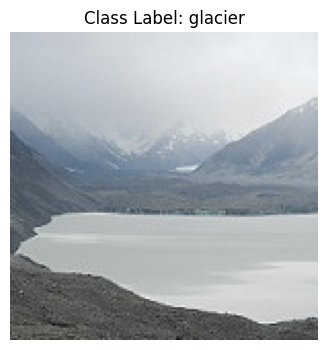

Sample 2: Image Path: /content/intel_image_01/Intel Image Dataset/glacier/23903.jpg, Class Label: glacier


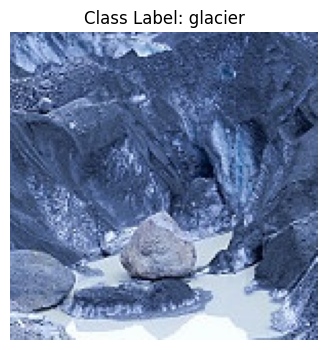

Sample 3: Image Path: /content/intel_image_01/Intel Image Dataset/sea/23324.jpg, Class Label: sea


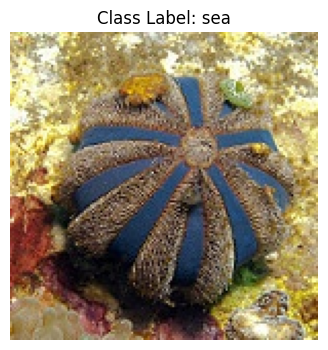

Sample 4: Image Path: /content/intel_image_01/Intel Image Dataset/street/23215.jpg, Class Label: street


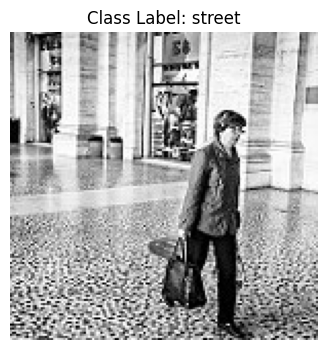

Sample 5: Image Path: /content/intel_image_01/Intel Image Dataset/sea/21598.jpg, Class Label: sea


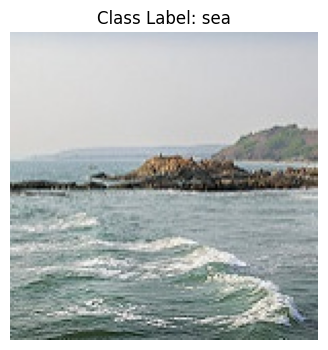

In [ ]:
def load_image_paths(image_folder):
    image_paths = []
    class_counts = defaultdict(int)

    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith(".jpg"):
                class_label = root.split("/")[-1]
                image_paths.append((os.path.join(root, file), class_label))
                class_counts[class_label] += 1

    print("Class labels and number of datasets in each class label:")
    for label, count in class_counts.items():
        print(f"Class label: {label}, Number of datasets: {count}")

    return image_paths

def print_random_samples(image_paths, num_samples=5):
    print(f"\nRandom samples of {num_samples} images:")
    samples = random.sample(image_paths, num_samples)
    for i, (image_path, class_label) in enumerate(samples, 1):
        print(f"Sample {i}: Image Path: {image_path}, Class Label: {class_label}")

        image = Image.open(image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Class Label: {class_label}")
        plt.axis('off')
        plt.show()

image_folder = extracted_folder_path
image_paths = load_image_paths(image_folder)

print_random_samples(image_paths)


In [ ]:
image_folder = extracted_folder_path
image_paths = load_image_paths(image_folder)
df = pd.DataFrame(image_paths, columns=['Image_Path', 'Class_Label'])
df.head()


Class labels and number of datasets in each class label:
Class label: sea, Number of datasets: 510
Class label: forest, Number of datasets: 474
Class label: mountain, Number of datasets: 525
Class label: buildings, Number of datasets: 437
Class label: street, Number of datasets: 501
Class label: glacier, Number of datasets: 553


,Image_Path,Class_Label
0,/content/intel_image_01/Intel Image Dataset/se...,sea
1,/content/intel_image_01/Intel Image Dataset/se...,sea
2,/content/intel_image_01/Intel Image Dataset/se...,sea
3,/content/intel_image_01/Intel Image Dataset/se...,sea
4,/content/intel_image_01/Intel Image Dataset/se...,sea


### **Split the Dataset**

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Number of samples in train set:", len(train_df))
print("Number of samples in validation set:", len(val_df))
print("Number of samples in test set:", len(test_df))

Number of samples in train set: 2400
Number of samples in validation set: 300
Number of samples in test set: 300


In [ ]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, test_tfms)

In [ ]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

### **Model**

### **GPT2.0 - Decoder Only Architecture**
![](https://miro.medium.com/v2/resize:fit:1400/1*bNQLzSDDD_9VO6P2_8bL6Q.png)
##### ***Adapted from: https://towardsdatascience.com/language-models-gpt-and-gpt-2-8bdb9867c50a***

### **The Vision Transformer**
![](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)
##### ***Adapted from: https://paperswithcode.com/method/vision-transformer***

### **VITGPT2.0 - Image Captioning Model**
![](https://ankur3107.github.io/assets/images/vision-encoder-decoder.png)
##### ***Adapted from: https://huggingface.co/nlpconnect/vit-gpt2-image-captioning***

i. GPT2 Attention Block

In [ ]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5

        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)


    def forward(self, x):
        b,t,c = x.shape
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c)

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

ii GPT2 Cross-Attention Block

In [ ]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


    def forward(self, q,k,v):
        b,t,c = q.shape

        q = self.q(q)
        k = self.k(k)
        v = self.v(v)

        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c)

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

iii. GPT2 Feed Forward Block

In [ ]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout

        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

iv. GPT2 Decoder Block

In [ ]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)

    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

v. Main Model (ViTGPT2)

In [ ]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config

        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches

        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)

        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight

    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)

    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)

        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable

        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')

    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)

        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True

    @classmethod
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]

        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        model.load_state_dict(sd)

        return model

    def forward(self,image,input_ids,labels=None):

        image = self.patch_embed(image)
        image = self._pos_embed(image)

        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)

        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)

        input_ids = self.transformer.ln_f(input_ids)

        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits

    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

        return sequence.cpu().flatten()

### **Training and Evaluation**

i. Fine-tuning and Training

In [ ]:
class Trainer:
    def __init__(self, model_config, train_config, dls):
        self.train_config = train_config
        self.model_config = model_config

        if torch.cuda.is_available():
            self.device = train_config.device
        else:
            self.device = 'cpu'

        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)

        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')

        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.scaler = GradScaler()

        self.train_dl, self.val_dl = dls

        total_steps = len(self.train_dl)

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None

        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])

    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')

    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)

    def train_one_epoch(self, epoch):
        prog = tqdm(self.train_dl, total=len(self.train_dl))
        running_loss = 0.

        for image, input_ids, labels in prog:
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image, input_ids, labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)

                running_loss += loss.item()
                prog.set_description(f'train loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)

        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss, train_pxp)

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        prog = tqdm(self.val_dl, total=len(self.val_dl))
        running_loss = 0.

        for image, input_ids, labels in prog:
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image, input_ids, labels)
                running_loss += loss.item()

                prog.set_description(f'valid loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)

        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss, val_pxp)

        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))

        for epoch in prog:
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')

            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)

            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()

            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()

            print(self.metrics.tail(1))

            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }

    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):

        self.model.eval()

        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id

        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)

        return caption

In [ ]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 25,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-5,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 32
)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,shuffle=True,pin_memory=False,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=False,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=False,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [ ]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

total_frozen_params=210236928
trainable parameters: 28366848


In [ ]:
trainer.fit()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/10 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  train_loss train_perplexity   val_loss val_perplexity
0  13.328862    614682.738761  15.582304  5852058.84274
saving best model...
unfreezing GPT2 entirely...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity   val_loss val_perplexity
1  11.953377    155340.883236  10.262603   28641.231383
saving best model...
total_frozen_params=0


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
2   7.452691      1724.496722  2.640111      14.014758
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
3   1.394694         4.033742  0.192609       1.212409
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
4   0.354882         1.426012  0.012699        1.01278
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
5   0.141158         1.151607  0.016772       1.016913


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
6   0.076783         1.079808  0.001924       1.001926
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
7   0.042743         1.043669  0.002013       1.002015


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
8   0.037348         1.038055  0.010314       1.010367


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
9   0.021428         1.021659  0.000115       1.000115
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
10   0.023186         1.023457  0.000051       1.000051
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
11   0.009611         1.009658  0.000008       1.000008
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
12   0.018768         1.018945  0.008707       1.008745


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
13    0.00922         1.009262  0.000014       1.000014


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
14   0.004624         1.004635  0.000039       1.000039


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
15   0.006718          1.00674  0.000361       1.000361


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
16   0.003215          1.00322  0.000004       1.000004
saving best model...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
17   0.003935         1.003942  0.000005       1.000005


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
18   0.002254         1.002257  0.000007       1.000007


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
19    0.00224         1.002243  0.000004       1.000004


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
20   0.004298         1.004307  0.00001        1.00001


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
21   0.002608         1.002611  0.000007       1.000007


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
22   0.002207         1.002209  0.000005       1.000005


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
23   0.002517          1.00252  0.000005       1.000005


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
24   0.001815         1.001817  0.000005       1.000005


{'best_perplexity': 1.0000035542841783, 'best_epoch': 16}

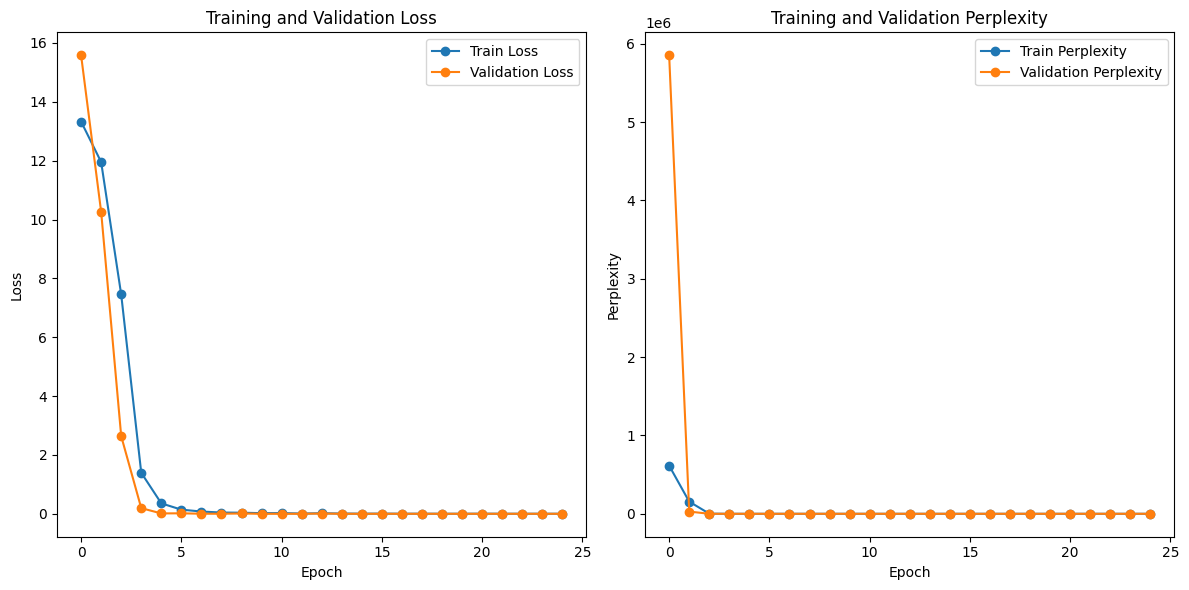

In [ ]:
def plot_training_metrics(metrics_df):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(metrics_df.index, metrics_df['train_loss'], label='Train Loss', marker='o')
    plt.plot(metrics_df.index, metrics_df['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics_df.index, metrics_df['train_perplexity'], label='Train Perplexity', marker='o')
    plt.plot(metrics_df.index, metrics_df['val_perplexity'], label='Validation Perplexity', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(trainer.metrics)


ii. Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    predicted_captions = []

    device = next(model.parameters()).device

    for images, input_ids, _ in dataloader:
        images = images.to(device)
        input_ids = input_ids.to(device)

        logits = model(images, input_ids=input_ids)
        predicted_captions.extend(torch.argmax(logits, dim=-1).tolist())

    return predicted_captions


predicted_captions = evaluate_model(trainer.model, test_dl)


def calculate_bleu_score(ground_truth_captions, predicted_captions, tokenizer):

    ground_truth_captions = [[caption.split()] for caption in ground_truth_captions]
    predicted_sentences = [tokenizer.decode(prediction, skip_special_tokens=True) for prediction in predicted_captions]
    predicted_captions = [prediction.split() for prediction in predicted_sentences]

    smoothing_function = SmoothingFunction().method4
    bleu_score = corpus_bleu(ground_truth_captions, predicted_captions, smoothing_function=smoothing_function)

    return bleu_score

ground_truth_captions = test_df['Class_Label'].tolist()

bleu_score = calculate_bleu_score(ground_truth_captions, predicted_captions, tokenizer)
print("BLEU Score:", bleu_score)


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


BLEU Score: 0.004082454921398235


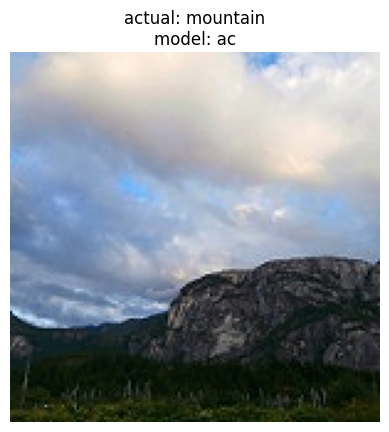

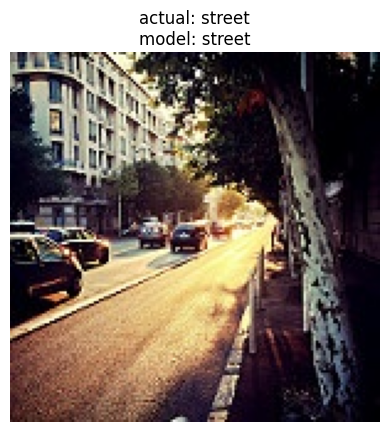

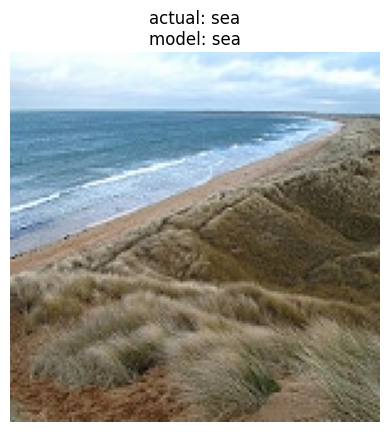

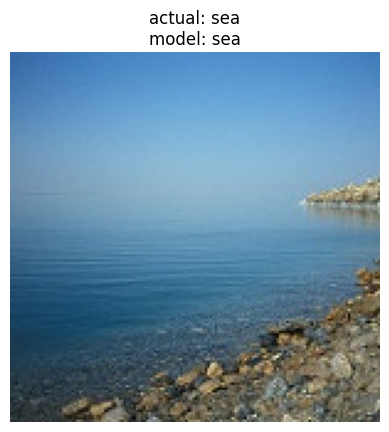

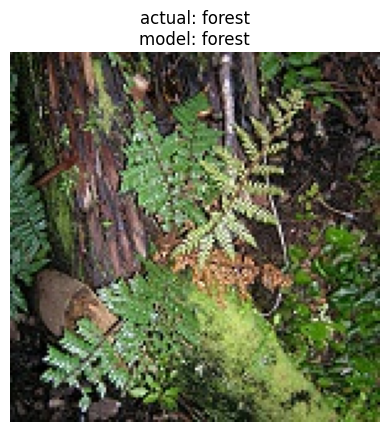

In [ ]:
for i in range(5):
    det = False
    test = test_df.sample(n=1).values[0]
    test_img, test_caption = test[0], test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5, 1.5)
    if i > 4:
        det = True
    gen_caption = trainer.generate_caption(test_img, temperature=t, deterministic=det, max_tokens=1)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}")
    plt.axis('off')
    plt.show()

### **Discussion of Model Performance**

A BLEU score of 0.004 indicates a very low similarity between the predicted captions generated by the model and the ground truth captions from the test dataset. Several factors could contribute to such a low BLEU score:

1. **Model Performance**: The model may not be effectively capturing the semantics and context of the images, leading to inaccurate or irrelevant captions.

2. **Data Quality**: The quality of the training data and test data might be poor or not representative of the real-world scenarios. If the test dataset contains images or captions that significantly differ from those in the training set, the model's performance could suffer.


3. **Hyperparameters**: The hyperparameters used during training, such as learning rate, batch size, and model architecture, can significantly impact the model's performance. Suboptimal hyperparameters might lead to poor performance on the test dataset.

4. **Evaluation Methodology**: The evaluation methodology used for computing the BLEU score could affect the results. Different smoothing functions or tokenization strategies might yield different scores.

5. **Tokenization and Preprocessing**: Inaccurate or ineffective tokenization and preprocessing of the captions can also impact the BLEU score. If the ground truth and predicted captions are not tokenized or preprocessed consistently, it can lead to discrepancies in the evaluation.

6. **Collect More Training Samples**: The training samples in our dataset seems to be small. Increasing the size of the dataset can significantly improve the performance of the model.

To improve the BLEU score, it's essential to analyze these factors and potentially adjust the model architecture, training process, data preprocessing, or evaluation strategy accordingly. Additionally, fine-tuning the model on a larger and more diverse dataset or exploring more advanced techniques for image captioning could also help improve performance.